In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def crop_face(image, padding=100):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
   
    results = face_mesh.process(image)
    
    if not results.multi_face_landmarks:return image
    
    landmarks = []
    height, width, _ = image.shape
    
    for face_landmarks in results.multi_face_landmarks:
        for landmark in face_landmarks.landmark:
            x, y = int(landmark.x * width), int(landmark.y * height)
            landmarks.append((x, y))
            
    
    x_coords, y_coords = zip(*landmarks)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    
    min_x, max_x = max(0, min_x - padding), min(width, max_x + padding)
    min_y, max_y = max(0, min_y - padding), min(height, max_y + padding)
    
    cropped_image = image[min_y:max_y, min_x:max_x]
    return cropped_image


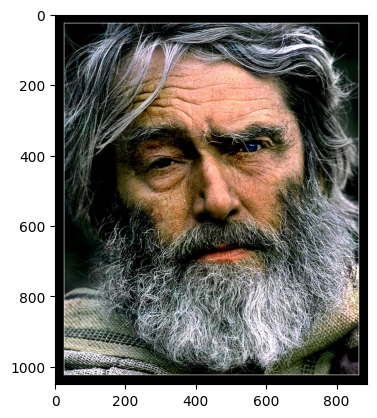

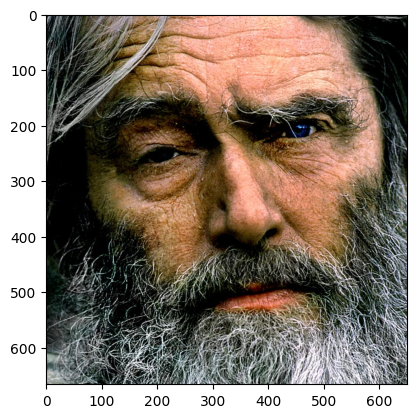

In [9]:
image = cv2.imread(r"C:\\Users\\DELL\\Documents\\FaceRec\\Dataset\\Humans\\1 (13).jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_image = crop_face(image, padding = 50)
plt.imshow(image);plt.show()
plt.imshow(cropped_image);plt.show()

In [8]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

results = face_mesh.process(image)

In [11]:
len(results.multi_face_landmarks)

1

In [10]:
cap = cv2.VideoCapture(0)
    
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    cropped = crop_face(frame,padding=50)
    if cropped is not None:
        cv2.imshow("Cropped Face", cropped)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

: 

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

class CropFaceTransform:
    def __init__(self, padding=50):
        self.padding = padding
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

    def __call__(self, image):
       
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.face_mesh.process(image_rgb)

        if not results.multi_face_landmarks:
            return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Return original image if no face detected

        landmarks = []q
        height, width, _ = image.shape

        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * width), int(landmark.y * height)
                landmarks.append((x, y))


        x_coords, y_coords = zip(*landmarks)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        min_x, max_x = max(0, min_x - self.padding), min(width, max_x + self.padding)
        min_y, max_y = max(0, min_y - self.padding), min(height, max_y + self.padding)

        cropped_image = image[min_y:max_y, min_x:max_x]
        return Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

def get_dataloaders(data_dir, image_size, batch_size, num_workers, split_ratios=(0.85, 0.10, 0.05)):
    transform = transforms.Compose([
        CropFaceTransform(padding=100), 
        transforms.Resize((image_size, image_size)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    full_dataset = datasets.ImageFolder(data_dir, transform=transform)
    total = len(full_dataset)

    train_len = int(total * split_ratios[0])
    val_len   = int(total * split_ratios[1])
    test_len  = total - train_len - val_len 

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader
